# Individual Analysis - Compton Scattering (Solutions)

The tasks for this experiment's analysis:

1. Prior to working on this noetbook, obtain the peak positions of the main photopeaks in the calibration data sets and the positions and full-width at half maxima of the photopeaks in the Compton scattering data.  Also obtain the integrated area of the photopeaks for the Compton scattering cross section data sets.  Then create these arrays:
   * Energy vs. photopeak position for the calibration data.
   * Scattering angle vs. peak position for the Compton scattering data.
   * Plastic thickness vs. photopeak area (net counts) for the cross section data.


2. Make a line fit to the calibration data to convert channel number to energy in MeV.  Save the calibration coefficients.


3. Create a function that will give the predicted channel number as a function of angle for the Compton-scattered photopeaks.  Then plot this prediction along with the measured photopeak positions (in channel numbers).


4. Convert the photopeak positions and FWHM for the Compton scattering data to energy units, using the calibration coefficients.


5. Create a fitting function, based on the expected energy vs. angle, for Compton scattering.  There should be one fit parameter: the incident energy of the gamma ray.  Use this function in the LMFIT `Model` to carry out a fit of the theoretical formula to the data.  Compare the fitted incident energy to the known incident energy from the Cs-137 source.


6. For the total scattering cross section, plot the photopeak net area (i.e., integrated counts) versus plastic thickness (in cm) on a single-log axis (vertical).  Fit this data set (either with a line to the log of the counts, or with an exponential decay to the counts) to obtain the gamma-attenuation coeffient $\mu$ (in cm<sup>-1</sup>) for Lucite plastic.  Then calculate the scattering cross-section per electron by means of the chemical data for Lucite (i.e., divide out the number of electrons per cm<sup>3</sup>).  

In [1]:
import numpy as np  # import the numpy library functions.
import scipy.constants as const # import physical constants
import matplotlib.pyplot as plt # plotting functions
import uncertainties as unc # Uncertainties package.  Good for simple error propagation
# directive below puts the plots in the notebook
%matplotlib inline

## 1. Build the data arrays

### Build the calibration arrays

You may use the enrgies you recorded in the Energy Measurements lab here, but the channel data will be different.

In [2]:
# Dictionaries contain calibration data.  Each list is in order of energy, 
# centroid and FWHM from DppMCA peak analysis

source_data = {'Na-22':[[0.511, 171.59, 14.93]],
              'Cs-137':[[0.662, 219.86, 17.87]],
              'Ba-133':[[0.03097, 11.35, 5.29],[0.081, 29.4, 5.12],[0.356, 121.04, 10.78]]}

# Then the lines below extract the requested arrays.  You could just enter them directly by hand.

cal_peaks = np.zeros(0)
cal_energies = np.zeros(0)
cal_delta_peaks = np.zeros(0)

for source,photopeaks in source_data.items():
    for a_peak in photopeaks:
        cal_energies = np.append(cal_energies,a_peak[0])
        cal_peaks = np.append(cal_peaks,a_peak[1])
        cal_delta_peaks = np.append(cal_delta_peaks,a_peak[2])        


### Build the Angle vs. Energy arrays

Print the data (a table is nice) to make sure you have it correctly.

In [3]:
# In my version, I put the data into a CSV text file that I read in with np.loadtxt()

angle_energy_data = np.loadtxt('Collected_angle_data.txt',delimiter=',')

print(' Angle | Peak Ch | FWHM (channels)')
print('-------|---------|-------------')
for datum in angle_energy_data:
    print('   {:3.0f} |  {:5.1f}  | {:4.1f}'.format(datum[0],datum[1],datum[2]))

expt_angle = angle_energy_data[:,0]
expt_chan = angle_energy_data[:,1]
expt_fwhm = angle_energy_data[:,2]

 Angle | Peak Ch | FWHM (channels)
-------|---------|-------------
     0 |  220.9  | 16.0
    25 |  195.1  | 30.0
    30 |  189.1  | 26.4
    40 |  169.3  | 35.5
    50 |  151.5  | 28.2
    60 |  134.6  | 26.8
    70 |  120.9  | 20.1
    80 |  108.5  | 19.7
    90 |   98.2  | 16.7
   100 |   88.9  | 14.7
   110 |   82.7  | 12.5
   120 |   76.7  | 10.0
   130 |   72.4  |  9.4
   140 |   69.2  |  8.0


### Build the thickness vs. Peak counts arrays

In [4]:
# In my version, I put the data into a CSV text file that I read in with np.loadtxt()

sigma_data = np.loadtxt('Collected_sigma_data.txt',delimiter=',')

print(' Thickness (cm) | Peak area (cts)')
print('----------------|-----------------')
for datum in sigma_data:
    print('       {:5.2f}    |  {:8.1f}  '.format(datum[0],datum[1]))

expt_thickness = sigma_data[:,0]
expt_counts = sigma_data[:,1]


 Thickness (cm) | Peak area (cts)
----------------|-----------------
        0.00    |  179327.0  
        2.46    |  139849.0  
        4.94    |  112971.0  
        7.42    |   90157.0  
       10.89    |   65996.0  
       15.55    |   43033.0  
       20.20    |   28078.0  


## 2. Obtain the calibration

### Fit to a line

Fit the calibration data.

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 5
    # variables        = 2
    chi-square         = 3.9274e-05
    reduced chi-square = 1.3091e-05
    Akaike info crit   = -54.7718709
    Bayesian info crit = -55.5529951
[[Variables]]
    slope:      0.00302643 +/- 2.0160e-05 (0.67%) (init = 0.003026432)
    intercept: -0.00667460 +/- 0.00275577 (41.29%) (init = -0.006674599)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.809


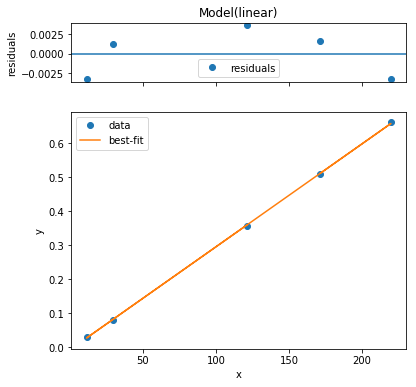

In [5]:
# Only need to import once:
from lmfit.models import LinearModel

line = LinearModel()

param_guess = line.guess(cal_energies, x=cal_peaks)
cal_linefit = line.fit(cal_energies, param_guess, x=cal_peaks)

print(cal_linefit.fit_report())

cal_linefit.plot();

### Save the calibration coefficients

In [6]:
# From the form "y = m*x + b", I'll create coefficients m and b with uncertainties

m = unc.ufloat(cal_linefit.params['slope'].value,cal_linefit.params['slope'].stderr)
b = unc.ufloat(cal_linefit.params['intercept'].value,cal_linefit.params['intercept'].stderr)

print('Slope = {:2uP} MeV/ch'.format(m))
print('Intercept = {:.2uP} MeV'.format(b))

cal_m = m.nominal_value
cal_b = b.nominal_value

Slope = 0.003026±0.000020 MeV/ch
Intercept = -0.0067±0.0028 MeV


## 3. Calculate the expected channel position as a function of angle

Write a function, given the channel position of the Cs-137 gamma energy, the scattering angle, and the known energy of the Cs-137 gamma ray that returns the expected channel postion of the Compton-scattered peak.  Then print a table of these positions at angles 20, 30, ..., 140 degrees.

The energy vs. angle formula, from Leo section 2.7:

$$E^{\prime}_{\gamma} = \frac{E_{\gamma}}{1+\frac{E_{\gamma}}{m_0c^2}\left(1-\cos\theta\right)}$$

So if the scattering angle is zero, the scattered energy $E_{\gamma}^{\prime}$ equals the incident energy $E_{\gamma}$. The channel numbers should be proportional to the energy.

In [7]:
def expected_Compton_chan(angle,gamma_energy=0.662,max_chan=219.86,degrees=True):
    mc2 = const.value(u'electron mass energy equivalent in MeV')
    E_ratio = gamma_energy/mc2
    if degrees:
        theta = angle*const.degree
    else:
        theta = angle
    return max_chan/(1.0+E_ratio*(1.0 - np.cos(theta)))


print('       | Expected | Measured')
print(' Angle |  channel |  channel')
print('-------|----------|------------')
for angle, chan in zip(expt_angle,expt_chan):
    print('   {:3.0f} |  {:5.1f}   |  {:5.1f}'.format(angle,expected_Compton_chan(angle),chan))
    #print(angle,expected_Compton_chan(angle),chan)

       | Expected | Measured
 Angle |  channel |  channel
-------|----------|------------
     0 |  219.9   |  220.9
    25 |  196.1   |  195.1
    30 |  187.3   |  189.1
    40 |  168.7   |  169.3
    50 |  150.3   |  151.5
    60 |  133.4   |  134.6
    70 |  118.7   |  120.9
    80 |  106.2   |  108.5
    90 |   95.8   |   98.2
   100 |   87.2   |   88.9
   110 |   80.3   |   82.7
   120 |   74.7   |   76.7
   130 |   70.3   |   72.4
   140 |   66.9   |   69.2


### Plot expected positions to measured positions

Use `plt.errorbar()` to plot the FWHM as error bars on the measured peak positions.

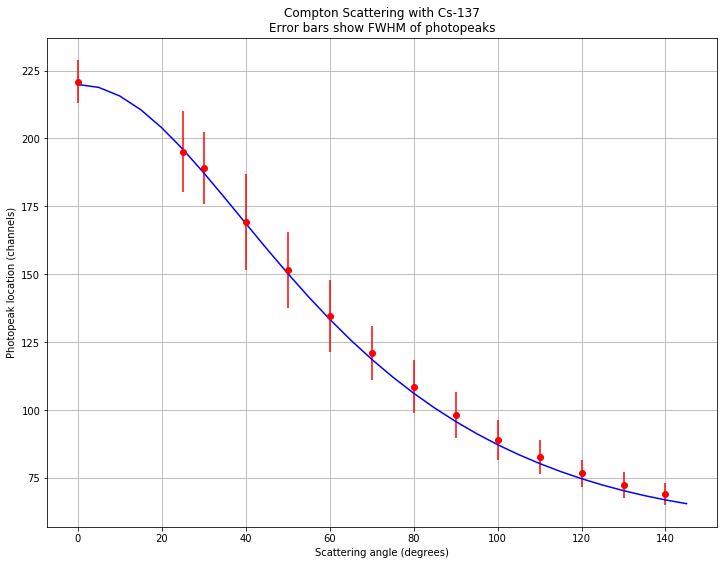

In [8]:
angles = np.arange(0,150,5)

plt.figure(figsize=(12,9))
plt.xlabel('Scattering angle (degrees)')
plt.ylabel('Photopeak location (channels)')
plt.title('Compton Scattering with Cs-137\nError bars show FWHM of photopeaks')
plt.grid()
plt.plot(angles,expected_Compton_chan(angles),'-b')
plt.errorbar(expt_angle,expt_chan,fmt='or',yerr=expt_fwhm/2);

## 4. Convert channels to energy

Use the calibration coefficients found earlier to convert channel numbers to energy in MeV.  Convert both peak positions and peak widths.

In [9]:
E_peaks = expt_chan*cal_m + cal_b
deltaE_peaks = expt_fwhm*cal_m

print(' Angle | Energy (MeV) | Width (MeV)')
print('-------|--------------|-------------')
for angle, E, deltaE in zip(expt_angle, E_peaks, deltaE_peaks):
    print('   {:3.0f} |  {:.4f}      | {:.4f}'.format(angle,E,deltaE))
    #print(angle,E,deltaE)

 Angle | Energy (MeV) | Width (MeV)
-------|--------------|-------------
     0 |  0.6620      | 0.0485
    25 |  0.5839      | 0.0908
    30 |  0.5656      | 0.0798
    40 |  0.5058      | 0.1073
    50 |  0.4519      | 0.0854
    60 |  0.4007      | 0.0810
    70 |  0.3593      | 0.0609
    80 |  0.3218      | 0.0595
    90 |  0.2904      | 0.0504
   100 |  0.2623      | 0.0443
   110 |  0.2436      | 0.0377
   120 |  0.2255      | 0.0303
   130 |  0.2125      | 0.0284
   140 |  0.2026      | 0.0242


## 5. Fit the data to the Compton scattering prediction

Ues the basic LMFIT `Model` to build a "model" around the Compton scattering predition for scattered energy vs. scattering angle.

[[Model]]
    Model(Compton_energy)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 14
    # variables        = 1
    chi-square         = 0.06538153
    reduced chi-square = 0.00502935
    Akaike info crit   = -73.1320190
    Bayesian info crit = -72.4929617
[[Variables]]
    gamma_energy:  0.66235424 +/- 0.00126589 (0.19%) (init = 0.6)


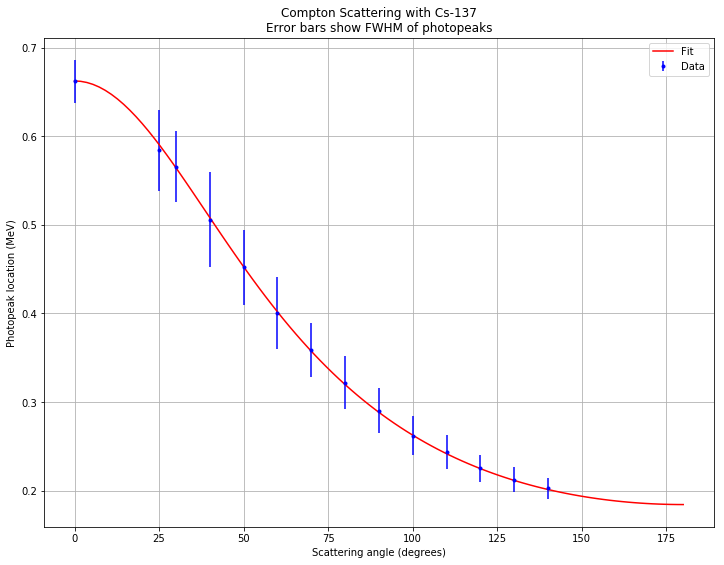

In [10]:
def Compton_energy(x, gamma_energy):
    mc2 = const.value(u'electron mass energy equivalent in MeV')
    E_ratio = gamma_energy/mc2
    theta = x*const.degree
    return gamma_energy/(1.0+E_ratio*(1.0 - np.cos(theta)))

from lmfit import Model

Cmodel = Model(Compton_energy)
result = Cmodel.fit(E_peaks, x=expt_angle, gamma_energy=0.6, weights=2/deltaE_peaks)

fit_angles = np.linspace(0,180,100)
print(result.fit_report())

plt.figure(figsize=(12,9))
plt.xlabel('Scattering angle (degrees)')
plt.ylabel('Photopeak location (MeV)')
plt.title('Compton Scattering with Cs-137\nError bars show FWHM of photopeaks')
plt.grid()
plt.errorbar(expt_angle, E_peaks, fmt='.b',yerr=deltaE_peaks/2, label="Data")
plt.plot(fit_angles, result.eval(result.params, x=fit_angles), 'r-', label='Fit')
plt.legend(loc='best');
#plt.show()

### Print the fitted energy

In your Group Document, compare this to the expected gamma energy

In [11]:
E_gamma = unc.ufloat(result.params['gamma_energy'].value,result.params['gamma_energy'].stderr)

print('Fitted incident gamma energy = {:.2uP} MeV'.format(E_gamma))


Fitted incident gamma energy = 0.6624±0.0013 MeV


## 6. Analyze the total cross-section data

### Plot the photopeak area vs. plastic thickness

On a semilog scale (vertical) it should look linear.

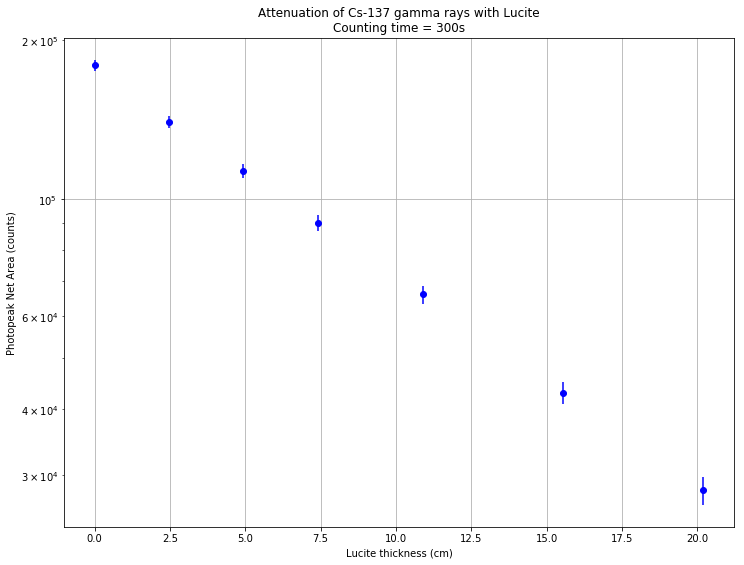

In [12]:
plt.figure(figsize=(12,9))
plt.xlabel('Lucite thickness (cm)')
plt.ylabel('Photopeak Net Area (counts)')
plt.title('Attenuation of Cs-137 gamma rays with Lucite\nCounting time = 300s')
plt.grid()
plt.errorbar(expt_thickness, expt_counts, fmt='ob', yerr=10*np.sqrt(expt_counts))
plt.yscale('log');

### Fit the data to obtain the absorption coefficient $\mu$

Either fit a line to the log of the photopeak area, or an exponential to the un-modified data, and obtain the coefficient (what are the units?).

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 7
    # variables        = 2
    chi-square         = 47.2726088
    reduced chi-square = 9.45452176
    Akaike info crit   = 17.3701462
    Bayesian info crit = 17.2619665
[[Variables]]
    slope:     -0.09135721 +/- 6.9809e-04 (0.76%) (init = -0.09119733)
    intercept:  12.0874289 +/- 0.00531720 (0.04%) (init = 12.08633)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.702


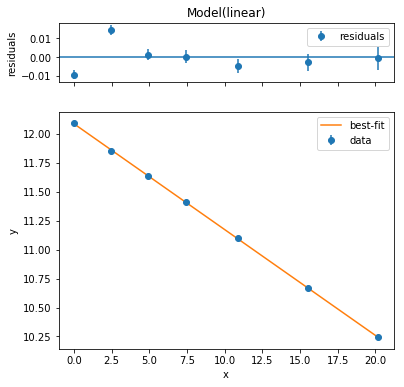

In [13]:
# I choose to use  a line fit

line = LinearModel()

param_guess = line.guess(np.log(expt_counts), x=expt_thickness)
linefit2 = line.fit(np.log(expt_counts), param_guess, x=expt_thickness, weights=expt_counts/np.sqrt(expt_counts))

print(linefit2.fit_report())

linefit2.plot();

### Obtain $\mu$ and calculate $\sigma_C$

From the fit result, obtain the absorption coefficient.  Then from the chemical composition of Lucite (acrylic plastic), determine the electron density, and use this to calculate the total Compton scettering cross section per electron.  Compare this result to the Klein-Nishina equation prediction, either from the graph in Leo or calculation from the formula.  

In [14]:
mu = unc.ufloat(-linefit2.params['slope'].value,linefit2.params['slope'].stderr)
print('Plastic absorption coefficient = {:.2uP} cm^-1'.format(mu))

rho = 3.77e23 # electron density of lucite per cubic cm
print('Estimated total cross section per electron = {:.2uP} cm^2'.format(mu/rho))

Plastic absorption coefficient = 0.09136±0.00070 cm^-1
Estimated total cross section per electron = (2.423±0.019)×10⁻²⁵ cm^2


In [15]:
def total_Compton_xsec(gamma_energy=0.662):
    '''Klein Nishina total cross section per electron'''
    mc2 = const.value(u'electron mass energy equivalent in MeV')
    r_e = const.value(u'classical electron radius')
    gamma = gamma_energy/mc2
    gammaPlus1 = 1.0 + gamma
    twogammaPlus1 = 1.0 + 2*gamma
    term1 = 2*(gammaPlus1)/twogammaPlus1 - np.log(twogammaPlus1)/gamma
    term1 *= gammaPlus1/(gamma*gamma)
    term2 = np.log(twogammaPlus1)/(2*gamma)
    term3 = (1 + 3*gamma)/(twogammaPlus1*twogammaPlus1)
    return 2*np.pi*r_e*r_e*(term1 + term2 - term3)

print('Klein-Nishina prediction for Cs-137 gamma = {:.4f} barn'.format(total_Compton_xsec(.662)*1e28))
    

Klein-Nishina prediction for Cs-137 gamma = 0.2561 barn


In [17]:
def diff_xsection(angle, gamma_energy=0.662):
    '''Klein-Nishina formula for differential cross-section per electron'''
    mc2 = const.value(u'electron mass energy equivalent in MeV')
    r_e = const.value(u'classical electron radius')
    theta = angle*const.degree
    gamma = gamma_energy/mc2
    f1 = gamma*(1-np.cos(theta))
    f2 = (1.0 + np.cos(theta)**2 + f1**2/(1.0 + f1))
    return (f2/2.0)*(r_e/(1.0 + f1))**2

print('Differential cross section for {:.0f} degrees = {:.4g} cm^2'.format(40.0,diff_xsection(40.0)*1e4))

Differential cross section for 40 degrees = 3.875e-26 cm^2


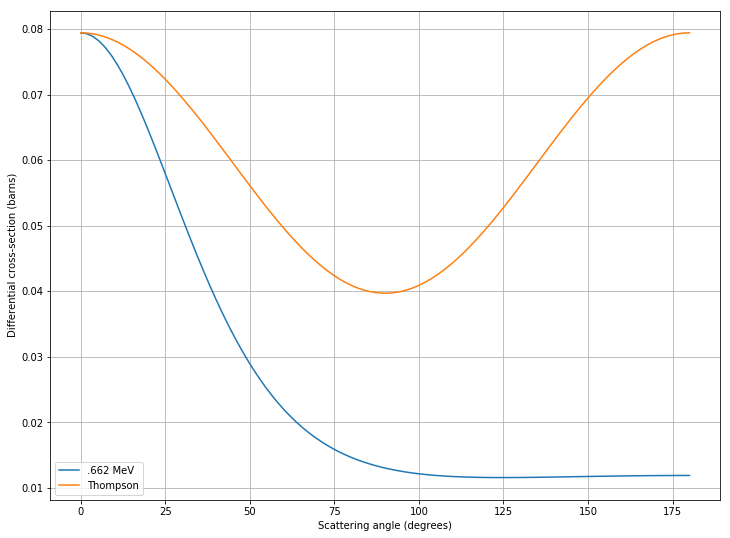

In [18]:
plt.figure(figsize=(12,9))
plt.xlabel('Scattering angle (degrees)')
plt.ylabel('Differential cross-section (barns)')
#plt.title('Attenuation of Cs-137 gamma rays with Lucite\nCounting time = 300s')
plt.grid()
plt.plot(fit_angles,diff_xsection(fit_angles)*1e28, label='.662 MeV')
plt.plot(fit_angles,diff_xsection(fit_angles,gamma_energy=0.0)*1e28, label='Thompson')
plt.legend();